<a href="https://colab.research.google.com/github/jameschapman19/cca_zoo/blob/master/tutorial_notebooks/cca_zoo_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A tutorial comparing the train and test correlations of different models on MNIST data

In [1]:
!pip install cca-zoo[deep,probabilistic]

     |████████████████████████████████| 59 kB 3.1 MB/s 
     |████████████████████████████████| 160 kB 14.5 MB/s 
     |████████████████████████████████| 28.5 MB 30 kB/s 
     |████████████████████████████████| 250 kB 46.0 MB/s 
     |████████████████████████████████| 154 kB 50.7 MB/s 
  Attempting uninstall: scipy
    Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [2]:
# Imports
import numpy as np
from cca_zoo.data import Noisy_MNIST_Dataset
import itertools
import matplotlib.pyplot as plt
from torch.utils.data import Subset
from torch import optim
from cca_zoo.deepmodels import objectives, architectures, DeepWrapper, DCCA,DCCA_NOI,DVCCA,DCCAE,DTCCA

# Load MNIST Data
N = 500
dataset = Noisy_MNIST_Dataset(mnist_type='FashionMNIST', train=True)
ids = np.arange(min(2 * N, len(dataset)))
np.random.shuffle(ids)
train_ids, val_ids = np.array_split(ids, 2)
val_dataset = Subset(dataset, val_ids)
train_dataset = Subset(dataset, train_ids)
test_dataset = Noisy_MNIST_Dataset(mnist_type='FashionMNIST', train=False)
test_ids = np.arange(min(N, len(test_dataset)))
np.random.shuffle(test_ids)
test_dataset = Subset(test_dataset, test_ids)
train_view_1, train_view_2, train_rotations, train_OH_labels, train_labels = train_dataset.dataset.to_numpy(
    train_dataset.indices)
val_view_1, val_view_2, val_rotations, val_OH_labels, val_labels = val_dataset.dataset.to_numpy(val_dataset.indices)
test_view_1, test_view_2, test_rotations, test_OH_labels, test_labels = test_dataset.dataset.to_numpy(
    test_dataset.indices)

# Settings

# The number of latent dimensions across models
latent_dims = 2
# The number of folds used for cross-validation/hyperparameter tuning
cv_folds = 5
# For running hyperparameter tuning in parallel (0 if not)
jobs = 2
# Number of iterations for iterative algorithms
max_iter = 2
# number of epochs for deep models
epochs = 50


Extracting ../../data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ../../data/FashionMNIST/raw




Extracting ../../data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ../../data/FashionMNIST/raw




Extracting ../../data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ../../data/FashionMNIST/raw




Extracting ../../data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ../../data/FashionMNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


# Canonical Correlation Analysis

In [3]:
from cca_zoo.models import CCA, CCA_ALS
"""
### Linear CCA by eigendecomposition
"""
linear_cca = CCA(latent_dims=latent_dims)

linear_cca.fit((train_view_1, train_view_2))

linear_cca_results = np.stack(
    (linear_cca.score((train_view_1, train_view_2)), linear_cca.score((test_view_1, test_view_2))))

"""
### Linear CCA by alternating least squares (can pass more than 2 views)
"""

linear_cca_als = CCA_ALS(latent_dims=latent_dims)

linear_cca_als.fit((train_view_1, train_view_2))

linear_cca_als_results = np.stack(
    (linear_cca_als.score((train_view_1, train_view_2)), linear_cca_als.score((test_view_1, test_view_2))))

# Partial Least Squares


In [6]:
from cca_zoo.models import PLS, PLS_ALS
"""
### PLS (2 views)
"""
pls = PLS(latent_dims=latent_dims)

pls.fit((train_view_1, train_view_2))

pls_results = np.stack(
    (pls.score((train_view_1, train_view_2)), pls.score((test_view_1, test_view_2))))

pls_als = PLS_ALS(latent_dims=latent_dims)

pls_als.fit((train_view_1, train_view_2))

pls_als_results = np.stack(
    (pls_als.score((train_view_1, train_view_2)), pls_als.score((test_view_1, test_view_2))))

# Extension to multiple views



In [8]:
from cca_zoo.models import GCCA, MCCA, PLS_ALS
"""
### (Regularized) Generalized CCA(can pass more than 2 views)
"""
train_view_3=train_view_1+np.random.rand(*train_view_1.shape)
test_view_3=test_view_1+np.random.rand(*test_view_1.shape)

# small ammount of regularisation added since data is not full rank
c=[0.5,0.5,0.5]

gcca = GCCA(latent_dims=latent_dims,c=c)

gcca.fit((train_view_1, train_view_2,train_view_3))

gcca_results = np.stack((gcca.score((train_view_1, train_view_2, train_view_3)), gcca.score((test_view_1, test_view_2, test_view_3))))

"""
### (Regularized) Multiset CCA(can pass more than 2 views)
"""

mcca = MCCA(latent_dims=latent_dims, c=c)

mcca.fit(train_view_1, train_view_2,train_view_1)

mcca_results = np.stack((mcca.score((train_view_1, train_view_2, train_view_3)), mcca.score((test_view_1, test_view_2, test_view_3))))

"""
### Multiset CCA by alternating least squares
"""
mcca_als = CCA_ALS(latent_dims=latent_dims, max_iter=max_iter)

mcca_als.fit((train_view_1, train_view_2,train_view_3))

mcca_als_results = np.stack(
    (mcca_als.score((train_view_1, train_view_2, train_view_3)), mcca_als.score((test_view_1, test_view_2, test_view_3))))

"""
### Multiset PLS by alternating least squares
"""
mcca_pls = PLS_ALS(latent_dims=latent_dims)

mcca_pls.fit(train_view_1, train_view_2,train_view_1)

mcca_pls_results = np.stack(
    (mcca_als.score((train_view_1, train_view_2, train_view_3)), mcca_pls.score((test_view_1, test_view_2, test_view_3))))

/usr/local/lib/python3.7/dist-packages/cca_zoo/models/innerloop.py:54: UserWarning: For more than 2 views require generalized=True
  'For more than 2 views require generalized=True')
/usr/local/lib/python3.7/dist-packages/cca_zoo/models/innerloop.py:54: UserWarning: For more than 2 views require generalized=True
  'For more than 2 views require generalized=True')
/usr/local/lib/python3.7/dist-packages/cca_zoo/models/innerloop.py:54: UserWarning: For more than 2 views require generalized=True
  'For more than 2 views require generalized=True')


# Tensor CCA

In [9]:
from cca_zoo.models import TCCA
"""
### (Regularized) Tensor CCA(can pass more than 2 views)
"""

tcca = TCCA(latent_dims=latent_dims, c=c)

#memory requirement for tensor is massive so take first 100 features
tcca.fit(train_view_1[:,:100], train_view_2[:,:100],train_view_3[:,:100])

tcca_results = np.stack((tcca.score(train_view_1[:,:100], train_view_2[:,:100], train_view_3[:,:100]), tcca.score(test_view_1[:,:100], test_view_2[:,:100], test_view_3[:,:100])))

reconstruction error=0.9899130939810213
iteration 1, reconstruction error: 0.986335772636382, decrease = 0.0035773213446393948, unnormalized = 0.00967533361443235
iteration 2, reconstruction error: 0.9838693672582574, decrease = 0.002466405378124592, unnormalized = 0.009651139728816703
iteration 3, reconstruction error: 0.9833381799357145, decrease = 0.0005311873225428698, unnormalized = 0.009645929115250876
iteration 4, reconstruction error: 0.9833359844350953, decrease = 2.1955006191953785e-06, unnormalized = 0.009645907578770572
iteration 5, reconstruction error: 0.9833359829419483, decrease = 1.4931469394241503e-09, unnormalized = 0.00964590756412374
PARAFAC converged after 5 iterations


# Weighted GCCA/Missing Observation GCCA

In [10]:
#observation_matrix
K = np.ones((3, N))
K[0, 200:] = 0
K[1, :100] = 0

#view weights
view_weights=[1,2,1.2]

c=[0.5,0.5,0.5]

gcca = GCCA(latent_dims=latent_dims,c=c,view_weights=view_weights)

gcca.fit(train_view_1, train_view_2,train_view_1,K=K)

gcca_results = np.stack((gcca.score((train_view_1, train_view_2)), gcca.score((test_view_1, test_view_2))))

# Rgularised CCA solutions based on alternating minimisation/alternating least squares

We implement Witten's penalized matrix decomposition form of sparse CCA using 'pmd'

We implement Waaijenborg's penalized CCA using elastic net using 'elastic'

We implement Mai's sparse CCA using 'scca'

Furthermore, any of these methods can be extended to multiple views. Witten describes this method explicitly.

cross validation
number of folds:  5
Best score :  1.2620305037608026
Standard deviation :  0.2369996319817725
{'c': (0.9, 0.9)}
cross validation
number of folds:  5
Best score :  1.2916265474859485
Standard deviation :  0.07763522831359103
{'c': (9, 9)}
cross validation
number of folds:  5
Best score :  0.7842743465173996
Standard deviation :  0.04016009741663166
{'c': (1e-05, 0.0001)}
cross validation
number of folds:  5
Best score :  0.8249028414277495
Standard deviation :  0.1155722983564989
{'c': (0.001, 0.0001), 'l1_ratio': (0.1, 0.01)}


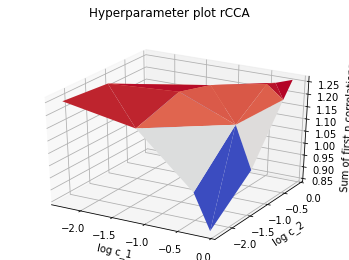

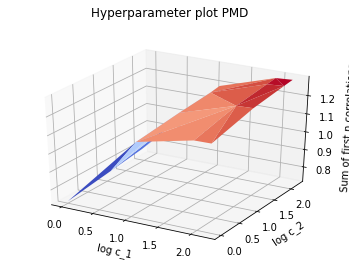

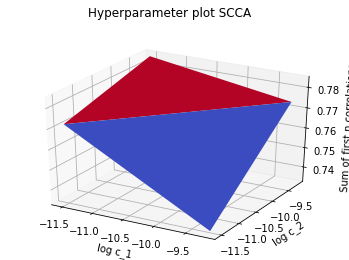

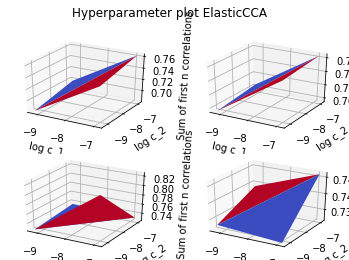

In [11]:
from cca_zoo.models import rCCA, PMD,SCCA,ElasticCCA
"""
### Ridge CCA (can pass more than 2 views)
"""
c1 = [0.1, 0.3, 0.7, 0.9]
c2 = [0.1, 0.3, 0.7, 0.9]
param_candidates = {'c': list(itertools.product(c1, c2))}

ridge = rCCA(latent_dims=latent_dims).gridsearch_fit(
    train_view_1,
    train_view_2,
    param_candidates=param_candidates,
    folds=cv_folds,
    verbose=True, jobs=jobs,
    plot=True)

ridge_results = np.stack((ridge.score(train_view_1,train_view_2), ridge.score((test_view_1, test_view_2))))

"""
### Sparse CCA (Penalized Matrix Decomposition) (can pass more than 2 views)
"""

# PMD
c1 = [1, 3, 7, 9]
c2 = [1, 3, 7, 9]
param_candidates = {'c': list(itertools.product(c1, c2))}

pmd = PMD(latent_dims=latent_dims, max_iter=max_iter).gridsearch_fit(
    train_view_1,
    train_view_2,
    param_candidates=param_candidates,
    folds=cv_folds,
    verbose=True, jobs=jobs,
    plot=True)

pmd_results = np.stack((pmd.score(train_view_1,train_view_2), pmd.score((test_view_1, test_view_2))))

"""
### Sparse CCA (can pass more than 2 views)
"""

# Sparse CCA
c1 = [0.00001, 0.0001]
c2 = [0.00001, 0.0001]
param_candidates = {'c': list(itertools.product(c1, c2))}

scca = SCCA(latent_dims=latent_dims, max_iter=max_iter).gridsearch_fit(
    train_view_1,
    train_view_2,
    param_candidates=param_candidates,
    folds=cv_folds,
    verbose=True,
    jobs=jobs, plot=True)

scca_results = np.stack(
    (scca.score(train_view_1,train_view_2), scca.score((test_view_1, test_view_2))))


"""
### Elastic CCA (can pass more than 2 views)
"""

# Elastic CCA
c1 = [0.001, 0.0001]
c2 = [0.001, 0.0001]
l1_1 = [0.01, 0.1]
l1_2 = [0.01, 0.1]
param_candidates = {'c': list(itertools.product(c1, c2)), 'l1_ratio': list(itertools.product(l1_1, l1_2))}

elastic = ElasticCCA(latent_dims=latent_dims,
                              max_iter=max_iter).gridsearch_fit(train_view_1,
                                                                train_view_2,
                                                                param_candidates=param_candidates,
                                                                folds=cv_folds,
                                                                verbose=True,
                                                                jobs=jobs,
                                                                plot=True)

elastic_results = np.stack(
    (elastic.score(train_view_1,train_view_2), elastic.score((test_view_1, test_view_2))))

# Kernel CCA

cross validation
number of folds:  5
Best score :  1.3501134380334654
Standard deviation :  0.2281843615309229
{'kernel': ['linear', 'linear'], 'c': (0.99, 0.99)}
cross validation
number of folds:  5
Best score :  1.254875171245565
Standard deviation :  0.2698670927837504
{'kernel': ['poly', 'poly'], 'degree': (3, 2), 'c': (0.9, 0.9)}
cross validation
number of folds:  5
Best score :  0.0
Standard deviation :  0.0
{'kernel': ['rbf', 'rbf'], 'gamma': (10.0, 10.0), 'c': (0.9, 0.9)}


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


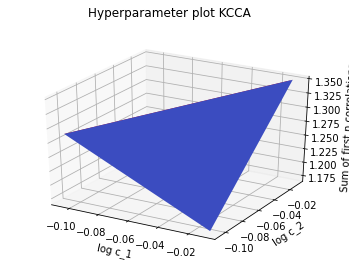

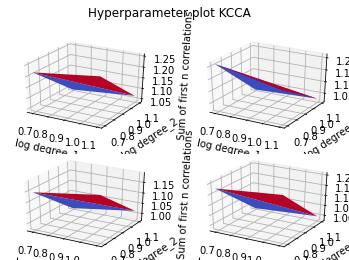

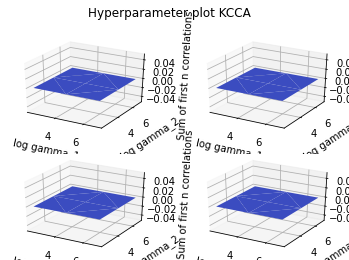

In [13]:
from cca_zoo.models import KCCA
"""
### Kernel CCA

Similarly, we can use kernel CCA methods with [method='kernel']

We can use different kernels and their associated parameters in a similar manner to before
- regularized linear kernel CCA: parameters :  'kernel'='linear', 0<'c'<1
- polynomial kernel CCA: parameters : 'kernel'='poly', 'degree', 0<'c'<1
- gaussian rbf kernel CCA: parameters : 'kernel'='gaussian', 'sigma', 0<'c'<1
"""
# %%
# r-kernel cca
c1 = [0.9, 0.99]
c2 = [0.9, 0.99]

param_candidates = {'kernel': [['linear', 'linear']], 'c': list(itertools.product(c1, c2))}

kernel_reg = KCCA(latent_dims=latent_dims).gridsearch_fit(train_view_1, train_view_2,
                                                          folds=cv_folds,
                                                          param_candidates=param_candidates,
                                                          verbose=True, jobs=jobs,
                                                          plot=True)
kernel_reg_results = np.stack((
    kernel_reg.score(train_view_1,train_view_2),
    kernel_reg.score((test_view_1, test_view_2))))

# kernel cca (poly)
degree1 = [2, 3]
degree2 = [2, 3]

param_candidates = {'kernel': [['poly', 'poly']], 'degree': list(itertools.product(degree1, degree2)),
                    'c': list(itertools.product(c1, c2))}

kernel_poly = KCCA(latent_dims=latent_dims).gridsearch_fit(train_view_1, train_view_2,
                                                           folds=cv_folds,
                                                           param_candidates=param_candidates,
                                                           verbose=True, jobs=jobs,
                                                           plot=True)

kernel_poly_results = np.stack((
    kernel_poly.score(train_view_1,train_view_2),
    kernel_poly.score((test_view_1, test_view_2))))

# kernel cca (gaussian)
gamma1 = [1e+1, 1e+2, 1e+3]
gamma2 = [1e+1, 1e+2, 1e+3]

param_candidates = {'kernel': [['rbf', 'rbf']], 'gamma': list(itertools.product(gamma1, gamma2)),
                    'c': list(itertools.product(c1, c2))}

kernel_gaussian = KCCA(latent_dims=latent_dims).gridsearch_fit(train_view_1, train_view_2,
                                                               folds=cv_folds,
                                                               param_candidates=param_candidates,
                                                               verbose=True, jobs=jobs,
                                                               plot=True)

kernel_gaussian_results = np.stack((
    kernel_gaussian.score(train_view_1,train_view_2),
    kernel_gaussian.score((test_view_1, test_view_2))))

# Deep CCA

DCCA can be optimized using Andrew's original tracenorm objective or Wang's DCCA by nonlinear orthogonal iterations using the argument als=True.

In [15]:
"""
### Deep Learning

We also have deep CCA methods (and autoencoder variants)
- Deep CCA (DCCA)
- Deep Canonically Correlated Autoencoders (DCCAE)

We introduce a Config class from configuration.py. This contains a number of default settings for running

"""

# %%
# DCCA
print('DCCA')
encoder_1 = architectures.Encoder(latent_dims=latent_dims, feature_size=784)
encoder_2 = architectures.Encoder(latent_dims=latent_dims, feature_size=784)
dcca_model = DCCA(latent_dims=latent_dims, encoders=[encoder_1, encoder_2])

dcca_model = DeepWrapper(dcca_model)

dcca_model.fit(train_dataset, val_dataset=val_dataset, epochs=epochs)

dcca_results = np.stack((dcca_model.score(train_dataset), dcca_model.score(test_dataset)))

# DCCA_NOI
print('DCCA by non-linear orthogonal iterations')
encoder_1 = architectures.Encoder(latent_dims=latent_dims, feature_size=784)
encoder_2 = architectures.Encoder(latent_dims=latent_dims, feature_size=784)
dcca_noi_model = DCCA_NOI(latent_dims=latent_dims, encoders=[encoder_1, encoder_2],N=len(train_dataset))

dcca_noi_model = DeepWrapper(dcca_noi_model)

dcca_noi_model.fit(train_dataset, val_dataset=val_dataset, epochs=epochs)

dcca_noi_results = np.stack(
    (dcca_noi_model.score(train_dataset), dcca_noi_model.score(test_dataset)))

DCCA
total parameters:  201476
====> Epoch: 1 Average train loss: -0.9981
====> Epoch: 1 Average val loss: -0.8626
Min loss -0.86
====> Epoch: 2 Average train loss: -0.9299
====> Epoch: 2 Average val loss: -0.9041
Min loss -0.90
====> Epoch: 3 Average train loss: -1.0023
====> Epoch: 3 Average val loss: -0.9573
Min loss -0.96
====> Epoch: 4 Average train loss: -1.3754
====> Epoch: 4 Average val loss: -1.2272
Min loss -1.23
====> Epoch: 5 Average train loss: -1.3115
====> Epoch: 5 Average val loss: -1.3330
Min loss -1.33
====> Epoch: 6 Average train loss: -1.3236
====> Epoch: 6 Average val loss: -1.3295
====> Epoch: 7 Average train loss: -1.4721
====> Epoch: 7 Average val loss: -1.4036
Min loss -1.40
====> Epoch: 8 Average train loss: -1.4509
====> Epoch: 8 Average val loss: -1.3854
====> Epoch: 9 Average train loss: -1.5068
====> Epoch: 9 Average val loss: -1.4361
Min loss -1.44
====> Epoch: 10 Average train loss: -0.9641
====> Epoch: 10 Average val loss: -0.8578
====> Epoch: 11 Averag

# DCCA with custom optimizers and schedulers

In [16]:
# DCCA
dcca_model = DCCA(latent_dims=latent_dims, encoders=[encoder_1, encoder_2],
                                objective=objectives.CCA)
optimizer = optim.Adam(dcca_model.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, 1)
# hidden_layer_sizes are shown explicitly but these are also the defaults
dcca_model = DeepWrapper(dcca_model)
dcca_model.fit(train_dataset, val_dataset=val_dataset,epochs=20)

total parameters:  201476
====> Epoch: 1 Average train loss: -0.4706
====> Epoch: 1 Average val loss: -0.4821
Min loss -0.48
====> Epoch: 2 Average train loss: -0.4874
====> Epoch: 2 Average val loss: -0.4858
Min loss -0.49
====> Epoch: 3 Average train loss: -0.5315
====> Epoch: 3 Average val loss: -0.5554
Min loss -0.56
====> Epoch: 4 Average train loss: -0.5573
====> Epoch: 4 Average val loss: -0.5772
Min loss -0.58
====> Epoch: 5 Average train loss: -0.5898
====> Epoch: 5 Average val loss: -0.5814
Min loss -0.58
====> Epoch: 6 Average train loss: -0.5802
====> Epoch: 6 Average val loss: -0.5876
Min loss -0.59
====> Epoch: 7 Average train loss: -0.6308
====> Epoch: 7 Average val loss: -0.6041
Min loss -0.60
====> Epoch: 8 Average train loss: -0.6710
====> Epoch: 8 Average val loss: -0.6593
Min loss -0.66
====> Epoch: 9 Average train loss: -0.6782
====> Epoch: 9 Average val loss: -0.6516
====> Epoch: 10 Average train loss: -0.7106
====> Epoch: 10 Average val loss: -0.6988
Min loss -0.

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


DeepWrapper(clip_value=inf, device='cpu', lr=None,
            model=DCCA(
  (encoders): ModuleList(
    (0): Encoder(
      (layers): Sequential(
        (0): Sequential(
          (0): Linear(in_features=784, out_features=128, bias=True)
          (1): ReLU()
        )
      )
      (fc): Linear(in_features=128, out_features=2, bias=True)
    )
    (1): Encoder(
      (layers): Sequential(
        (0): Sequential(
          (0): Linear(in_features=784, out_features=128, bias=True)
          (1): ReLU()
        )
      )
      (fc): Linear(in_features=128, out_features=2, bias=True)
    )
  )
),
            optimizer=LBFGS (
Parameter Group 0
    history_size: 100
    line_search_fn: None
    lr: 0.001
    max_eval: 25
    max_iter: 20
    tolerance_change: 1e-09
    tolerance_grad: 1e-07
),
            scheduler=None, tensorboard=False, tensorboard_tag=None)

# DGCCA and DMCCA for more than 2 views

The only change we need to make is to the objective argument to perform DGCCA and DMCCA.

In [17]:
# DGCCA
print('DGCCA')
encoder_1 = architectures.Encoder(latent_dims=latent_dims, feature_size=784)
encoder_2 = architectures.Encoder(latent_dims=latent_dims, feature_size=784)
dgcca_model = DCCA(latent_dims=latent_dims, encoders=[encoder_1, encoder_2], objective=objectives.GCCA)

dgcca_model = DeepWrapper(dgcca_model)

dgcca_model.fit(train_dataset, val_dataset=val_dataset, epochs=epochs)

dgcca_results = np.stack(
    (dgcca_model.score(train_dataset), dgcca_model.score(test_dataset)))

# DMCCA
print('DMCCA')
encoder_1 = architectures.Encoder(latent_dims=latent_dims, feature_size=784)
encoder_2 = architectures.Encoder(latent_dims=latent_dims, feature_size=784)
dmcca_model = DCCA(latent_dims=latent_dims, encoders=[encoder_1, encoder_2], objective=objectives.MCCA)

dmcca_model = DeepWrapper(dmcca_model)

dmcca_model.fit(train_dataset, val_dataset=val_dataset, epochs=epochs)

dmcca_results = np.stack(
    (dmcca_model.score(train_dataset), dmcca_model.score(test_dataset)))

DGCCA
total parameters:  201476
====> Epoch: 1 Average train loss: -0.6296
====> Epoch: 1 Average val loss: -0.4897
Min loss -0.49
====> Epoch: 2 Average train loss: -0.6655
====> Epoch: 2 Average val loss: -0.6607
Min loss -0.66
====> Epoch: 3 Average train loss: -0.7246
====> Epoch: 3 Average val loss: -0.6947
Min loss -0.69
====> Epoch: 4 Average train loss: -1.0191
====> Epoch: 4 Average val loss: -0.8824
Min loss -0.88
====> Epoch: 5 Average train loss: -1.0317
====> Epoch: 5 Average val loss: -0.9209
Min loss -0.92
====> Epoch: 6 Average train loss: -1.0649
====> Epoch: 6 Average val loss: -0.9798
Min loss -0.98
====> Epoch: 7 Average train loss: -1.0067
====> Epoch: 7 Average val loss: -1.1014
Min loss -1.10
====> Epoch: 8 Average train loss: -1.0957
====> Epoch: 8 Average val loss: -1.0689
====> Epoch: 9 Average train loss: -1.1242
====> Epoch: 9 Average val loss: -1.0697
====> Epoch: 10 Average train loss: -1.1462
====> Epoch: 10 Average val loss: -1.0426
====> Epoch: 11 Avera

# Deep Canonically Correlated Autoencoders
We need to add decoders in order to model deep canonically correlated autoencoders and we also use the DCCAE class which inherits from DCCA

In [18]:
# DCCAE
print('DCCAE')
encoder_1 = architectures.Encoder(latent_dims=latent_dims, feature_size=784)
encoder_2 = architectures.Encoder(latent_dims=latent_dims, feature_size=784)
decoder_1 = architectures.Decoder(latent_dims=latent_dims, feature_size=784)
decoder_2 = architectures.Decoder(latent_dims=latent_dims, feature_size=784)
dccae_model = DCCAE(latent_dims=latent_dims, encoders=[encoder_1, encoder_2], decoders=[decoder_1, decoder_2])

dccae_model = DeepWrapper(dccae_model)

#can also pass a tuple of numpy arrays
dccae_model.fit((train_view_1, train_view_2), epochs=epochs)

dccae_results = np.stack(
    (dccae_model.score(train_dataset), dccae_model.score(test_dataset)))

DCCAE
total parameters:  404516
====> Epoch: 1 Average train loss: 0.1114
====> Epoch: 2 Average train loss: -0.0935
====> Epoch: 3 Average train loss: -0.2261
====> Epoch: 4 Average train loss: -0.3211
====> Epoch: 5 Average train loss: -0.3961
====> Epoch: 6 Average train loss: -0.4561
====> Epoch: 7 Average train loss: -0.5069
====> Epoch: 8 Average train loss: -0.5503
====> Epoch: 9 Average train loss: -0.5878
====> Epoch: 10 Average train loss: -0.6198
====> Epoch: 11 Average train loss: -0.6481
====> Epoch: 12 Average train loss: -0.6737
====> Epoch: 13 Average train loss: -0.6971
====> Epoch: 14 Average train loss: -0.7183
====> Epoch: 15 Average train loss: -0.7373
====> Epoch: 16 Average train loss: -0.7550
====> Epoch: 17 Average train loss: -0.7712
====> Epoch: 18 Average train loss: -0.7862
====> Epoch: 19 Average train loss: -0.8001
====> Epoch: 20 Average train loss: -0.8133
====> Epoch: 21 Average train loss: -0.8255
====> Epoch: 22 Average train loss: -0.8370
====> Epoc

# Deep Variational CCA

In [19]:
"""
### Deep Variational Learning
Finally we have Deep Variational CCA methods.
- Deep Variational CCA (DVCCA)
- Deep Variational CCA - private (DVVCA_p)

These are both implemented by the DVCCA class with private=True/False and both_encoders=True/False. If both_encoders,
the encoder to the shared information Q(z_shared|x) is modelled for both x_1 and x_2 whereas if both_encoders is false
it is modelled for x_1 as in the paper
"""

# %%
# DVCCA (technically bi-DVCCA)
print('DVCCA')
encoder_1 = architectures.Encoder(latent_dims=latent_dims, feature_size=784, variational=True)
encoder_2 = architectures.Encoder(latent_dims=latent_dims, feature_size=784, variational=True)
decoder_1 = architectures.Decoder(latent_dims=latent_dims, feature_size=784, norm_output=True)
decoder_2 = architectures.Decoder(latent_dims=latent_dims, feature_size=784, norm_output=True)
dvcca_model = DVCCA(latent_dims=latent_dims, encoders=[encoder_1, encoder_2], decoders=[decoder_1, decoder_2])

dvcca_model = DeepWrapper(dvcca_model)

dvcca_model.fit(train_dataset, val_dataset=val_dataset, epochs=epochs)

dvcca_model_results = np.stack(
    (dvcca_model.score(train_dataset), dvcca_model.score(test_dataset)))

# DVCCA_private (technically bi-DVCCA_private)
print('DVCCA_private')
encoder_1 = architectures.Encoder(latent_dims=latent_dims, feature_size=784, variational=True)
encoder_2 = architectures.Encoder(latent_dims=latent_dims, feature_size=784, variational=True)
private_encoder_1 = architectures.Encoder(latent_dims=latent_dims, feature_size=784, variational=True)
private_encoder_2 = architectures.Encoder(latent_dims=latent_dims, feature_size=784, variational=True)
decoder_1 = architectures.Decoder(latent_dims=latent_dims * 2, feature_size=784, norm_output=True)
decoder_2 = architectures.Decoder(latent_dims=latent_dims * 2, feature_size=784, norm_output=True)
dvccap_model = DVCCA(latent_dims=latent_dims, encoders=[encoder_1, encoder_2], decoders=[decoder_1, decoder_2],
                           private_encoders=[private_encoder_1, private_encoder_2])

dvccap_model = DeepWrapper(dvccap_model)

dvccap_model.fit(train_dataset, val_dataset=val_dataset, epochs=epochs)

dvccap_model_results = np.stack(
    (dvccap_model.score(train_dataset), dvccap_model.score(test_dataset)))

DVCCA
total parameters:  405032
====> Epoch: 1 Average train loss: 1109.0348
====> Epoch: 1 Average val loss: 1105.1040
Min loss 1105.10
====> Epoch: 2 Average train loss: 1105.1630
====> Epoch: 2 Average val loss: 1101.3570
Min loss 1101.36
====> Epoch: 3 Average train loss: 1101.4145
====> Epoch: 3 Average val loss: 1097.5241
Min loss 1097.52
====> Epoch: 4 Average train loss: 1097.6603
====> Epoch: 4 Average val loss: 1094.0863
Min loss 1094.09
====> Epoch: 5 Average train loss: 1093.6983
====> Epoch: 5 Average val loss: 1090.0576
Min loss 1090.06
====> Epoch: 6 Average train loss: 1090.2796
====> Epoch: 6 Average val loss: 1086.7369
Min loss 1086.74
====> Epoch: 7 Average train loss: 1086.5696
====> Epoch: 7 Average val loss: 1083.3143
Min loss 1083.31
====> Epoch: 8 Average train loss: 1083.1616
====> Epoch: 8 Average val loss: 1079.9952
Min loss 1080.00
====> Epoch: 9 Average train loss: 1079.5566
====> Epoch: 9 Average val loss: 1076.0510
Min loss 1076.05
====> Epoch: 10 Average

# Convolutional Deep CCA (and using other architectures)
We provide a standard CNN encoder and decoder but users can build their own encoders and decoders by inheriting BaseEncoder and BaseDecoder for seamless integration with the pipeline

In [25]:
print('Convolutional DCCA')
encoder_1 = architectures.CNNEncoder(latent_dims=latent_dims, channels=[3, 3])
encoder_2 = architectures.CNNEncoder(latent_dims=latent_dims, channels=[3, 3])
dcca_conv_model = DCCA(latent_dims=latent_dims, encoders=[encoder_1, encoder_2])

dcca_conv_model = DeepWrapper(dcca_conv_model)

# to change the models used change the cfg.encoder_models. We implement a CNN_Encoder and CNN_decoder as well
# as some based on brainnet architecture in cca_zoo.architectures. Equally you could pass your own encoder/decoder models

dcca_conv_model.fit((train_view_1.reshape((-1, 1, 28, 28)), train_view_2.reshape((-1, 1, 28, 28))), epochs=10)

dcca_conv_results = np.stack((
    dcca_conv_model.score((test_view_1.reshape((-1, 1, 28, 28)),test_view_2.reshape((-1, 1, 28, 28)))), 
    dcca_conv_model.score((test_view_1.reshape((-1, 1, 28, 28)),test_view_2.reshape((-1, 1, 28, 28))))))

Convolutional DCCA
total parameters:  9568
====> Epoch: 1 Average train loss: -0.3919
====> Epoch: 2 Average train loss: -0.5392
====> Epoch: 3 Average train loss: -0.6492
====> Epoch: 4 Average train loss: -0.7309
====> Epoch: 5 Average train loss: -0.8090
====> Epoch: 6 Average train loss: -0.8930
====> Epoch: 7 Average train loss: -0.9763
====> Epoch: 8 Average train loss: -1.0496
====> Epoch: 9 Average train loss: -1.1256
====> Epoch: 10 Average train loss: -1.1877


# DTCCA

In [21]:
# %%
# DTCCA
print('DTCCA')
encoder_1 = architectures.Encoder(latent_dims=latent_dims, feature_size=784)
encoder_2 = architectures.Encoder(latent_dims=latent_dims, feature_size=784)
dtcca_model = DTCCA(latent_dims=latent_dims, encoders=[encoder_1, encoder_2])

dtcca_model = DeepWrapper(dtcca_model)

dtcca_model.fit(train_dataset, val_dataset=val_dataset, epochs=epochs)

dtcca_results = np.stack((dtcca_model.score(train_dataset), dtcca_model.score(test_dataset)))

DTCCA
total parameters:  201476


/usr/local/lib/python3.7/dist-packages/tensorly/backend/core.py:885: UserWarning: In partial_svd: converting to NumPy. Check SVD_FUNS for available alternatives if you want to avoid this.
  warnings.warn('In partial_svd: converting to NumPy.'


====> Epoch: 1 Average train loss: 0.0000
====> Epoch: 1 Average val loss: 0.0000
Min loss 0.00
====> Epoch: 2 Average train loss: 0.0000
====> Epoch: 2 Average val loss: 0.0000
Min loss 0.00
====> Epoch: 3 Average train loss: 0.0000
====> Epoch: 3 Average val loss: 0.0000
====> Epoch: 4 Average train loss: 0.0000
====> Epoch: 4 Average val loss: 0.0000
====> Epoch: 5 Average train loss: 0.0000
====> Epoch: 5 Average val loss: 0.0000
====> Epoch: 6 Average train loss: 0.0000
====> Epoch: 6 Average val loss: 0.0000
====> Epoch: 7 Average train loss: 0.0000
====> Epoch: 7 Average val loss: 0.0000
====> Epoch: 8 Average train loss: 0.0000
====> Epoch: 8 Average val loss: 0.0000
====> Epoch: 9 Average train loss: 0.0000
====> Epoch: 9 Average val loss: 0.0000
====> Epoch: 10 Average train loss: 0.0000
====> Epoch: 10 Average val loss: 0.0000
====> Epoch: 11 Average train loss: 0.0000
====> Epoch: 11 Average val loss: 0.0000
====> Epoch: 12 Average train loss: 0.0000
====> Epoch: 12 Average